In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [30]:
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
columns = ['user-id','activity','timestamp','x-axis','y-axis','z-axis']
df = pd.read_csv('WISDM_ar_v1.1_raw.txt',header=None,names=columns)
df['z-axis'].replace(to_replace=r';',value=r'',regex=True,inplace=True)
df['z-axis'] = df['z-axis'].apply(convert_to_float)
df.dropna(axis=0, how='any', inplace=True)

In [29]:
def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan

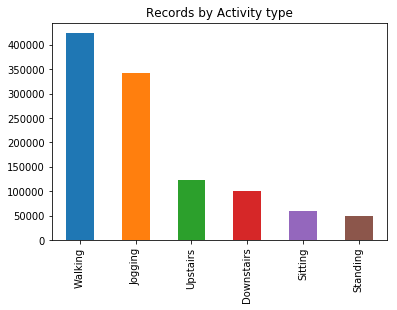

In [31]:
#Visualizing the data based on activity type
df['activity'].value_counts().plot(kind='bar',title='Records by Activity type')
plt.show()

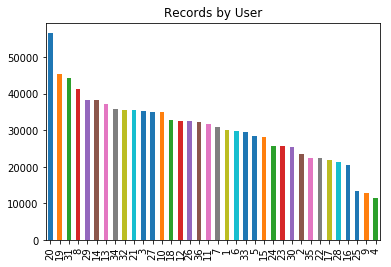

In [32]:
#visualizing the data based on user id
df['user-id'].value_counts().plot(kind='bar',title='Records by User')
plt.show()

In [33]:
#Adding a new column for encoded activities
activity_labels = LabelEncoder()
df['ActivityEncoded'] = activity_labels.fit_transform(df['activity'].values.ravel())

In [34]:
#Splitting into training and testing data
df_train = df[df['user-id'] > 28]
df_test = df[df['user-id'] <= 28]

In [35]:
#Normisation of data
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [36]:
from scipy import stats #statistical functions of scipy library
#TIME_PERIODS stores the length of the time segment
TIME_PERIODS = 80
#STEP_DISTANCE determines the amount of overlap between two consecutive time segments
STEP_DISTANCE = 40
# x, y, z acceleration as features
N_FEATURES = 3

segments = []
labels = []
for i in range(0, len(df_train) - TIME_PERIODS, STEP_DISTANCE):
    xs = df_train['x-axis'].values[i: i + TIME_PERIODS]
    ys = df_train['y-axis'].values[i: i + TIME_PERIODS]
    zs = df_train['z-axis'].values[i: i + TIME_PERIODS]
    # Retrieve the most often used label in this segment
    label = stats.mode(df_train['ActivityEncoded'][i: i + TIME_PERIODS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

# Bring the segments into a better shape
x_train = np.asarray(segments, dtype= np.float32).reshape(-1, TIME_PERIODS, N_FEATURES)
y_train = np.asarray(labels)

In [37]:
num_time_periods, num_sensors = x_train.shape[1],x_train.shape[2]
num_classes = activity_labels.classes_.size

In [38]:
x_train = x_train.reshape(x_train.shape[0], num_time_periods*num_sensors)

In [39]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [40]:
y_train_hot = np_utils.to_categorical(y_train, num_classes)

In [41]:
model_dnn = Sequential()
model_dnn.add(Reshape((TIME_PERIODS, 3), input_shape=(num_time_periods*num_sensors,)))
model_dnn.add(Dense(100, activation='relu'))
model_dnn.add(Dense(100, activation='relu'))
model_dnn.add(Dense(100, activation='relu'))
model_dnn.add(Flatten())
model_dnn.add(Dense(num_classes, activation='softmax'))
model_dnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

In [45]:
BATCH_SIZE = 100
EPOCHS = 50
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]
history = model_dnn.fit(x_train, y_train_hot,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=callbacks_list,validation_split=0.2,verbose=1)

Train on 5267 samples, validate on 1317 samples
Epoch 1/50
5267/5267 [==============================] - 1s 146us/step - loss: 1.3602 - acc: 0.4792 - val_loss: 1.4201 - val_acc: 0.6264
Epoch 2/50
5267/5267 [==============================] - 1s 136us/step - loss: 1.3115 - acc: 0.5493 - val_loss: 1.3590 - val_acc: 0.6538
Epoch 3/50
5267/5267 [==============================] - 1s 134us/step - loss: 1.2587 - acc: 0.6119 - val_loss: 1.3002 - val_acc: 0.6545
Epoch 4/50
5267/5267 [==============================] - 1s 134us/step - loss: 1.2059 - acc: 0.6446 - val_loss: 1.2515 - val_acc: 0.6553
Epoch 5/50
5267/5267 [==============================] - 1s 141us/step - loss: 1.1564 - acc: 0.6628 - val_loss: 1.2115 - val_acc: 0.6560
Epoch 6/50
5267/5267 [==============================] - 1s 137us/step - loss: 1.1097 - acc: 0.6873 - val_loss: 1.1558 - val_acc: 0.6568
Epoch 7/50
5267/5267 [==============================] - 1s 144us/step - loss: 1.0649 - acc: 0.6987 - val_loss: 1.1161 - val_acc: 0.6576


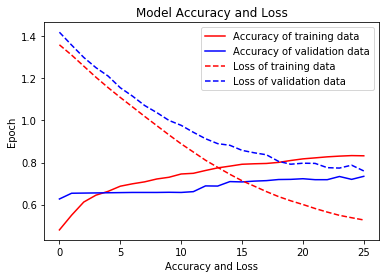

In [47]:
plt.figure()
plt.plot(history.history['acc'],'r',label='Accuracy of training data')
plt.plot(history.history['val_acc'],'b',label='Accuracy of validation data')
plt.plot(history.history['loss'],'r--',label='Loss of training data')
plt.plot(history.history['val_loss'],'b--',label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.xlabel('Accuracy and Loss')
plt.ylabel('Epoch')
plt.legend()
plt.show()

In [48]:
#Normisation of test data
pd.options.mode.chained_assignment = None  # default='warn'
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()
# Round numbers
df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [49]:
from scipy import stats #statistical functions of scipy library
#TIME_PERIODS stores the length of the time segment
TIME_PERIODS = 80
#STEP_DISTANCE determines the amount of overlap between two consecutive time segments
STEP_DISTANCE = 40
# x, y, z acceleration as features
N_FEATURES = 3

segments = []
labels = []
for i in range(0, len(df_test) - TIME_PERIODS, STEP_DISTANCE):
    xs = df_test['x-axis'].values[i: i + TIME_PERIODS]
    ys = df_test['y-axis'].values[i: i + TIME_PERIODS]
    zs = df_test['z-axis'].values[i: i + TIME_PERIODS]
    # Retrieve the most often used label in this segment
    label = stats.mode(df_test['ActivityEncoded'][i: i + TIME_PERIODS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

# Bring the segments into a better shape
x_test = np.asarray(segments, dtype= np.float32).reshape(-1, TIME_PERIODS, N_FEATURES)
y_test = np.asarray(labels)

num_time_periods, num_sensors = x_test.shape[1],x_test.shape[2]
num_classes = activity_labels.classes_.size

x_test = x_test.reshape(x_test.shape[0], num_time_periods*num_sensors)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_test_hot = np_utils.to_categorical(y_test, num_classes)

In [50]:
score = model_dnn.evaluate(x_test,y_test_hot,verbose=1)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

20868/20868 [==============================] - 1s 64us/step

Accuracy on test data: 0.70

Loss on test data: 0.87


In [ ]:
import coremltools
coreml_model = coremltools.converters.keras.convert(model_dnn,
                                                    input_names=['acceleration'],
                                                    output_names=['output'],
                                                    class_labels=LABELS)

print(coreml_model)
coreml_model.author = 'Harsha'
coreml_model.license = 'N/A'
coreml_model.short_description = 'Activity based recognition based on WISDM dataset'
coreml_model.output_description['output'] = 'Probability of each activity'
coreml_model.output_description['classLabel'] = 'Labels of activity'

coreml_model.save('HARClassifier.mlmodel')

In [ ]:
print('\nPrediction from Keras:')
test_record = x_test[1].reshape(1,input_shape)
keras_prediction = np.argmax(model_m.predict(test_record), axis=1)
print(le.inverse_transform(keras_prediction)[0])
print('\nPrediction from Coreml:')
coreml_prediction = coreml_model.predict({'acceleration': test_record.reshape(input_shape)})
print(coreml_prediction["classLabel"])